https://youtu.be/oBIkr7CAE6g

Binary semantic segmentation using U-Net
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/

In [1]:
pip install keras-unet-collection

Note: you may need to restart the kernel to use updated packages.


In [1]:
from keras_unet_collection import losses

In [43]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob

In [44]:
image_directory = 'data/training/images'
gt_directory = 'data/training/groundtruth'
SIZE = 608
PATCH_SIZE = 16

In [45]:
# store train RGB images
image_names = glob.glob(image_directory + '/*.png')
#images = [cv2.imread(img) for img in image_names]
images = [cv2.resize(cv2.imread(img),(SIZE,SIZE)) for img in image_names]
image_dataset = np.array(images)


In [46]:
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
#gt = [cv2.imread(gt,0) for gt in gt_names]
gt = [cv2.resize(cv2.imread(gt,0),(SIZE,SIZE)) for gt in gt_names]
gt_dataset = np.array(gt)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [58]:
print("Image data shape is: ", image_dataset.shape)
print("gt data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 608, 608, 3)
gt data shape is:  (100, 608, 608, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0 255]


In [59]:
# binary labels
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
# resize and define binary threshold
gt_dataset = []
for gt in gt_names:
    gt_img = cv2.imread(gt,0)
    gt_img = cv2.resize(gt_img,(SIZE,SIZE))
    _,gt_img = cv2.threshold(gt_img, 120, 255, cv2.THRESH_BINARY)
    gt_dataset.append(gt_img)

gt_dataset = np.array(gt_dataset)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [60]:
print("Image data shape is: ", image_dataset.shape)
print("get data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 608, 608, 3)
get data shape is:  (100, 608, 608, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0 255]


In [61]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [62]:
# Extract patches from input images

n = len(image_dataset)

img_patches = [img_crop(image_dataset[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]
gt_patches = [img_crop(gt_dataset[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [63]:
#Normalize images
img_patches = img_patches /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
gt_patches = gt_patches /255.  #PIxel values will be 0 or 1

In [64]:
back = np.sum(gt_patches == 1,axis=(0,1,2))
road = np.sum(gt_patches == 0,axis=(0,1,2))
road/(back+road)[0]

array([0.79915391])

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_patches, gt_patches, test_size = 0.20,random_state=43)


In [80]:
X_test.shape

(28880, 16, 16, 3)

In [66]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [67]:
IMG_HEIGHT = img_patches.shape[1]
IMG_WIDTH  = img_patches.shape[2]
IMG_CHANNELS = img_patches.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [68]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [69]:
def loss_fn(y_true, y_pred):
    return losses.focal_tversky(y_true, y_pred, alpha=0.2)

## First model

In [71]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=loss_fn, metrics=['accuracy'])


sigmoid


In [109]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d_285 (Conv2D)            (None, 16, 16, 64)   1792        ['input_16[0][0]']               
                                                                                                  
 batch_normalization_270 (Batch  (None, 16, 16, 64)  256         ['conv2d_285[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_270 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_270[0][

In [72]:
fit = model.fit(X_train, y_train, 
                    batch_size = 256, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/25


2021-12-13 19:20:26.864592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


452/452 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.8091

2021-12-13 19:22:24.575681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


452/452 [==============================] - 126s 273ms/step - loss: 0.5893 - accuracy: 0.8091 - val_loss: 0.7044 - val_accuracy: 0.6709
Epoch 2/25
452/452 [==============================] - 122s 270ms/step - loss: 0.5256 - accuracy: 0.8383 - val_loss: 0.5459 - val_accuracy: 0.8383
Epoch 3/25
452/452 [==============================] - 121s 269ms/step - loss: 0.5022 - accuracy: 0.8438 - val_loss: 0.5022 - val_accuracy: 0.8454
Epoch 4/25
452/452 [==============================] - 121s 269ms/step - loss: 0.4904 - accuracy: 0.8470 - val_loss: 0.5266 - val_accuracy: 0.8371
Epoch 5/25
452/452 [==============================] - 122s 270ms/step - loss: 0.4743 - accuracy: 0.8516 - val_loss: 0.4859 - val_accuracy: 0.8509
Epoch 6/25
452/452 [==============================] - 122s 270ms/step - loss: 0.4644 - accuracy: 0.8542 - val_loss: 0.5017 - val_accuracy: 0.8467
Epoch 7/25
452/452 [==============================] - 122s 270ms/step - loss: 0.4560 - accuracy: 0.8568 - val_loss: 0.4921 - val_accura

In [73]:
#Save the model for future use
model.save('first_model_patched.h5')

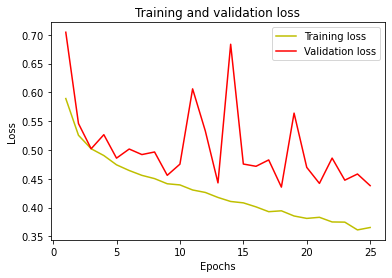

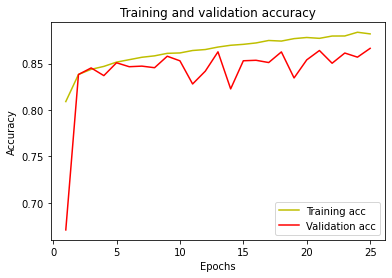

In [74]:
#plot the training and validation accuracy and loss at each epoch
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
#Load previously saved model
from keras.models import load_model
model = load_model('first_model_patched.h5', compile=False)


NameError: name 'y_pred' is not defined

In [91]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

In [92]:
from tensorflow.keras.metrics import MeanIoU

In [93]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6564559


In [111]:
test_img_names = glob.glob('data/test_set_images/*/*.png')
test_img_names.sort()
test_images = np.array([cv2.imread(img) for img in test_img_names])
test_images.shape

(50, 608, 608, 3)

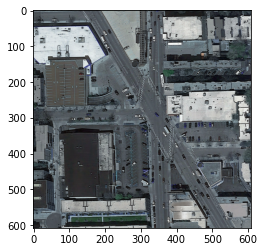

In [113]:
import random
image_number = random.randint(0, len(test_images)-1)
plt.imshow(test_images[image_number])

(1, 608, 608, 3)
(608, 608)


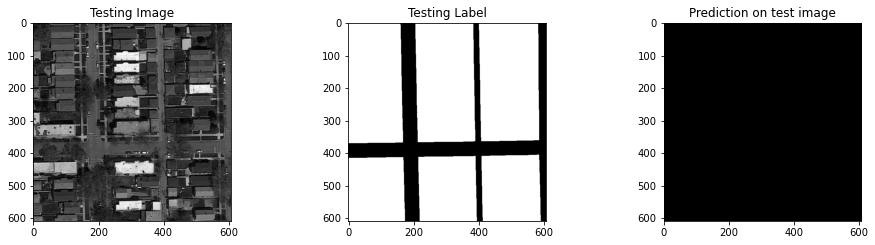

In [58]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()